In [1]:
pwd()

"/Users/kyan/Projects/qgplsim"

# Start

In [9]:
# run this ceil if source codes was edited
include("DGP.ji")
# include("qgplsim.ji")
include("MonteCarloSIM.ji")
using Statistics, LinearAlgebra, Clustering
using LaTeXStrings, Plots

import Base.Threads.@threads

# QGPLSIM fitting

In [15]:
# run this ceil for different data sets

α = [1.0, 0.5] # single index for x
θ = [0.5, -1.0]  # linear for x, <α, θ> = 0 for identification
γ = [0.5, 0.5] # single index for z
β = [0.5, 1.0] # linear for z
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)

n = 500
fx = 2 # y = f(x), fx for different f(x)     
                # fx = 1, y = X*θ + Z*β + (X*α + Z*γ .- 1).^2 + 0.2ϵ
                # fx = 2, y = X*θ + Z*β + log.(1 .+ exp.(X*α + Z*γ .- 1)) + 0.2ϵ

ifz = true # if false, Z = 0, i.e. no category varible
dist = 1 # 0 for gauss, 1 for Cauchy
X, Z, y = dgp(n, γ, θ, α, β, fx, dist,  ifz)
# p = length(α)
# q = length(γ)
τ = 0.5

# Estimation 

model1 = qgplsim.model(X, Z, y, τ)
alpha_type = 1
# different weight of sum on alpha 
# 0 for true alpha, using α in DGP
# 1 for global: ∑ij sum(Bi - Bj) / n;
# 2 for local: ∑z ∑ij (bzi - bzj) * nz / n;
# when Z = 0, global == local
@time alpha1, gamma, theta, beta = qgplsim.estimator(model1, alpha_type)
coefa = 1 #/ alpha[1]
coefg = 1 #/ gamma[1]
println("Estimation of index coefs: ")
println("̂α => ", coefa * alpha1)
println("̂γ => ", gamma)

println("Estimation of linear coefs: ")
println("̂θ => ", theta)
println("̂β => ", beta)

# theta * alpha

  1.649977 seconds (2.58 M allocations: 12.296 GiB, 22.88% gc time)
Estimation of index coefs: 
̂α => [0.802984690219814; 0.5959996537520718]
̂γ => [0.46029119196896917, 1.0739593929396016]
Estimation of linear coefs: 
̂θ => [0.7230677594544469 -0.9741823458759781]
̂β => [0.7596493863506224, 1.239419870954846]


# Paths of $g(x \alpha + z \gamma)$ and $\nabla g$

$\alpha = \hat{\alpha}$,
$z \in S_z$

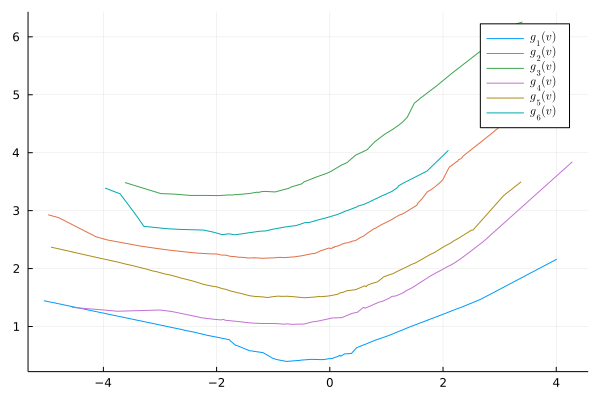

In [11]:
alphap = 1.0 * alpha1
v = X * alphap # g(Xα + Zγ) => univar func. g(v + zγ) after α was determined and  Z = z
categ, index = model1.categ, model1.index
g, dg = qgplsim.Gz_DGz(v, Z, y - X * transpose(theta), 0.5, -0.4) # g: g(v), dg: g'(v)
p1 = plot()
for m in 1:6
    vm = v[index[categ[m]]]
    gm = g[index[categ[m]]]
    indm = sortperm(vm)
    sorted_gm = gm[indm]
    sorted_vm = vm[indm]

    plot!(p1, sorted_vm, sorted_gm, label = L"g_{%$m} (v)")

end
fig

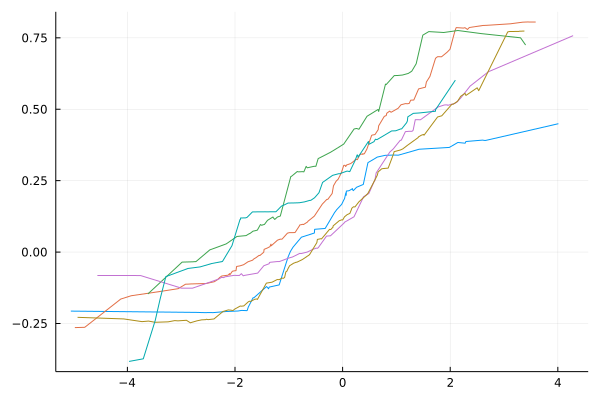

In [12]:
p2= plot()
for m in 1:6
    vm = v[index[categ[m]]]
    dgm = dg[index[categ[m]]]
    indm = sortperm(vm)
    sorted_dgm = dgm[indm]
    sorted_vm = vm[indm]
    plot!(p2, sorted_vm, sorted_dgm, label = L"\nabla g_{%$m} (v)")

end
plot(p1, p2, layout = (1,2))

# Monte Carlo Simulation

In [487]:
Threads.nthreads()

2

In [9]:
include("MonteCarloSIM.ji")

main (generic function with 4 methods)

In [29]:
α = [1.0, 0.5] # single index for x
θ = [1.0, -2.0]  # linear for x, <α, θ> = 0 for identification
γ = [0.5, 1.0] # single index for z
β = [1.0, 0.5] # linear for z
# Q(y|x, z) = Xθ + Zβ + g(Xα + Zγ)
n = 400
fx = 2
dist = 1 # Cauchy
rep = 20 # MC rept. times

20

In [30]:
Alpha, Gamma, Theta, Beta = MonteCarlo(n, γ, θ, α, β, fx, dist, rep)
mean(Gamma, dims = 1)

1×2 Matrix{Float64}:
 0.563527  1.35609

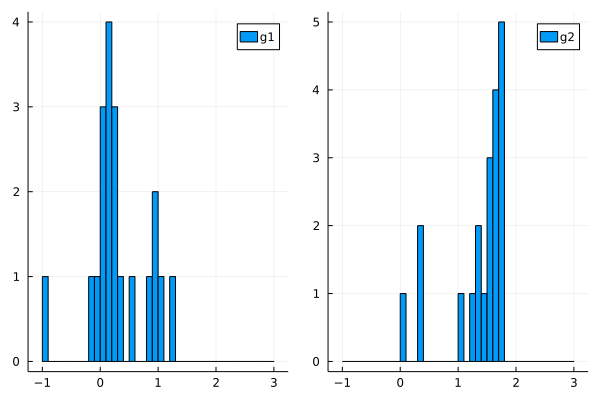

In [27]:
p1 = histogram(Gamma[:,1], bins = -1:0.1:3, label = "g1")
p2 = histogram(Gamma[:,2], bins = -1:0.1:3, label = "g2")
plot(p1, p2, layout = (1, 2))

In [ ]:
mb = mean(Beta, dims = 1)

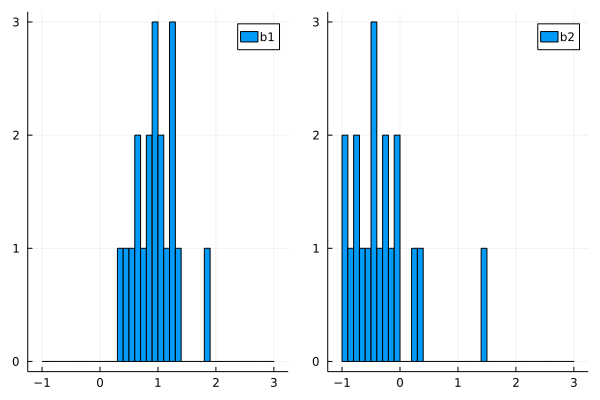

In [28]:

p1 = histogram(Beta[:,1], bins = -1:0.1:3, label = "b1")
p2 = histogram(Beta[:,2], bins = -1:0.1:3, label = "b2")
plot(p1, p2, layout = (1, 2))

In [14]:
ma = mean(Alpha, dims = 1)

1×2 Matrix{Float64}:
 0.866363  0.481433

In [16]:
mt = mean(Theta, dims = 1)

1×2 Matrix{Float64}:
 1.08132  -1.93303

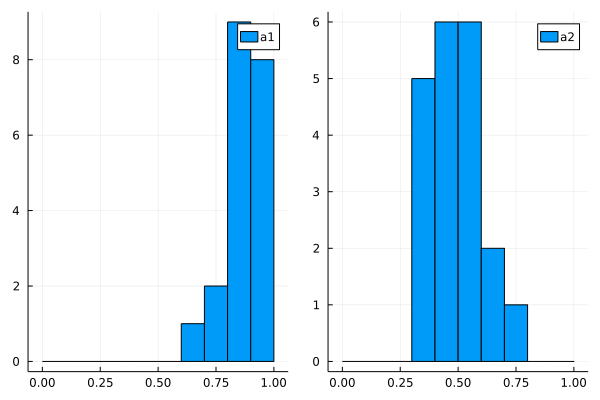

In [24]:
p1 = histogram(Alpha[:,1], bins = 0:0.1:1, label = "a1")
p2 = histogram(Alpha[:,2], bins = 0:0.1:1, label = "a2")
plot(p1, p2, layout = (1, 2))

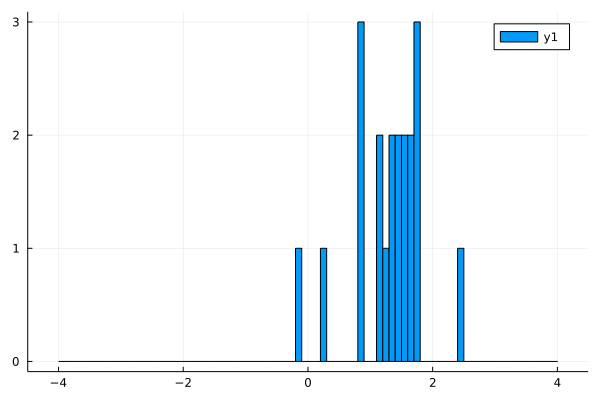

In [502]:
histogram(Beta[:,1], bins = -4:0.1:4)